In [116]:
import pandas as pd
import numpy as np
import nltk
from collections import defaultdict

### Import Scripts

In [117]:
episode_scripts_df = pd.read_csv("../05_Data/02_Clean/scripts_by_law_order_half.csv",index_col=0)
len(episode_scripts_df) #Number of Scripts should be 456

456

In [118]:
episode_scripts_df.head(3)

,season_ep,first,second
0,s01e01,Narrator In the criminal justice system the pe...,even know he was wrong You know now Nowwe have...
1,s01e02,Narrator In the criminal justice system the pe...,the screwdrivers We were going to rob some loc...
2,s01e03,Narrator In the criminal justice system the pe...,havent even thought of Logan The guys jive Im ...


### Truncate Script Half
Although the episodes are split in half between Law and Order, the cutoff may not be exactly at the 50% mark so this section allows you to toggle the section back if it helps with the clustering

In [119]:
def reduce_script(row,start,end):
    text = row.split()
    start_pos = int(len(text)*start)
    end_pos = int(len(text)*end)
    text = text[start_pos:end_pos]
    return " ".join(text)

In [120]:
episode_scripts_df["second"] = episode_scripts_df["second"].apply(reduce_script,start=.20,end=.85)
episode_scripts_df.head()

,season_ep,first,second
0,s01e01,Narrator In the criminal justice system the pe...,on liver rounds Wasnt he And he did tell you t...
1,s01e02,Narrator In the criminal justice system the pe...,when you questioned her She was upset She said...
2,s01e03,Narrator In the criminal justice system the pe...,one second And Jack Curry whos done this twice...
3,s01e04,Narrator In the criminal justice system the pe...,point out that the States case is less than co...
4,s01e05,Narrator In the criminal justice system the pe...,The guy offered a 50000 reward Crime of passio...


### Process Text for NLP

#### 1. Removing punctuation - Removed by the previous notebook (04_Clean_Scripts_by_Episode.ipynb) already
#### 2. Make Lowercase - Even though CountVectorizer and TFIDF already do this, why not do it manually here

In [121]:
episode_scripts_df["second"] = episode_scripts_df["second"].apply(lambda x: x.lower())
episode_scripts_df["second"][0][4500:4750]

'was his speech slurred not so i remember did he seem drunk in any way i never saw anyone hold his liquor better stone during your years of research into alcoholism dr walters have you ever observed people who appear to be sober but are in fact drunk '

#### 3. Remove Numbers

In [122]:
from string import digits
remove_digits = str.maketrans('', '', digits)
episode_scripts_df["second"] = episode_scripts_df["second"].apply(lambda x: x.translate(remove_digits))
episode_scripts_df["second"][0][4500:4750]

'eech slurred not so i remember did he seem drunk in any way i never saw anyone hold his liquor better stone during your years of research into alcoholism dr walters have you ever observed people who appear to be sober but are in fact drunk it happens'

#### 4. Import Stopwords and  Remove Stopwords

Import Main Stopword List

In [123]:
law_order_stopwords = list(pd.read_csv("../05_Data/02_Clean/all_stopwords.csv",index_col=0)['0'])
law_order_stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

Import Stopwords generated by topics from the 1st Half of the episode

In [124]:
topic_stopwords = list(pd.read_csv("../05_Data/02_Clean/Half_Episode_Stopwords/first_half_stopwords.csv",header=None)[0])

List of personal nouns & personal relationships

In [125]:
people_stopwords = ["father","wife","mother","husband","miss","daughter","doctor","girl","detective",
                    "brother","boy","officer","parent","cop","cousin","sweetie","prosecutor","daddy",
                    "sir","juror","counselor","grand","jury","chief","men","married","spouse","girlfriend",
                    "granddaughter","spousal","child","family","uncle"]

Common Words

In [126]:
common_stopwords = ["cocaine","phone","firm","sexual","estate","actually","voice"]

# common_stopwords = ["actually","shed","statement","book","information","order","count","hit","room",
#                    "game","play","body","cocaine"]

#["book","bar","bureau","suspect","immunity","clerk","confessed","statement","information", 
#                   "indictment", "order", "district", "file", "report", "dismiss", "memo", "motion", "intent",
#                   "count", "building", "degree", "president", "committee", "duty", "command", "prosecution",
#                   "department"]

Combine Stopword Lists

In [127]:
law_order_stopwords = law_order_stopwords + topic_stopwords + people_stopwords + common_stopwords

Remove Stopwords

In [128]:
from nltk.tokenize import word_tokenize

def remove_stopwords(row):
    tokens = word_tokenize(row)
    tokens_clean = [word for word in tokens if not word in law_order_stopwords] 
    text_clean = " ".join(tokens_clean)
    return text_clean.strip()

In [129]:
episode_scripts_df["second"] = episode_scripts_df["second"].apply(remove_stopwords)

In [130]:
episode_scripts_df["second"][0][2500:2750]

'mean fact full possession faculties weighing pounds several drinks appears quite sober makes mistake mistake necessarily caused drinking might made mistake anyway obviously impossible year old man know weve got auster mortons bedside prescribing kill'

#### 5. Lemmatize Text

In [131]:
replace_dict = {"abused":"abuse", "adopted":"adoption", "bombing":"bomb", "fighting":"fight",
                "gangster":"gang","jew":"jewish","marriage":"married","medication":"medicine",
                "pregnancy":"pregnant","senate":"senator","shoot":"shooter","stabbed":"stab",
                "stabbing":"stab","suicidal":"suicide","russia":"russian","raped":"rape"}

In [132]:
from nltk.stem import WordNetLemmatizer

def lemma_my_text(row):
    tokens = word_tokenize(row)
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(y) for y in tokens]
    tokens_lemma = [x if x not in replace_dict else replace_dict[x] for x in tokens_lemma] #remap words in dict
    text_lemma = " ".join(tokens_lemma)
    return text_lemma.strip()

In [133]:
episode_scripts_df["second"] = episode_scripts_df["second"].apply(lemma_my_text)
episode_scripts_df["second"][0][2500:2750]

'lty weighing pound several drink appears quite sober make mistake mistake necessarily caused drinking might made mistake anyway obviously impossible year old man know weve got auster morton bedside prescribing killed feel rope better go back every sh'

### Vectorize

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

I included stopwords again here in case the stemming process truncated variants of each stopword, they will be caught again here

In [135]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),
                             stop_words=law_order_stopwords,
                             token_pattern="\\b[a-zA-Z][a-zA-Z][a-zA-Z]+\\b", #words with >= 3 alpha chars
                             max_df=.50,
                             min_df=.025) 
X = vectorizer.fit_transform(episode_scripts_df["second"])
X.shape

(456, 2557)

In [136]:
n_grams = list(vectorizer.get_feature_names())
counts = list(sum(X.toarray()))
word_counts = list(zip(n_grams, counts))
pd.DataFrame(word_counts).sort_values(by=1,ascending=False).head(5)

,0,1
1896,remember,11.221096
329,business,10.011759
2280,tape,9.986326
2391,truth,9.668619
1025,guilty,9.527044


In [137]:
X_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
X_df.head()

,abandoned,ability,able,absolute,absolutely,absurd,abusive,academic,accept,acceptable,...,written,wrote,yard,yelling,yep,yesterday,yet,younger,yourhonol,zero
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.035171,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.027294,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.047659,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.047501,0.000000,0.0,0.0,0.0,0.0,0.028620,0.0,0.0,0.0


### NMF Model

In [138]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=16)
nmf_vecs = nmf.fit_transform(X_df) 

In [139]:
len(nmf_vecs)

456

### Explore Topics

#### How many episodes per topic?

In [140]:
topic, episode_count = np.unique(nmf_vecs.argmax(axis = 1), return_counts=True)   # Number of episodes in each category
topic_count_df = pd.DataFrame(list(zip(topic,episode_count)))
topic_count_df = topic_count_df.drop([0],axis=1)
topic_count_df = topic_count_df.rename({1:"num_eps"},axis=1)
topic_count_df

,num_eps
0,43
1,43
2,32
3,29
4,13
5,33
6,57
7,21
8,16
9,5


#### Print Out Topics

In [141]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "Topic #%d: " % index
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, "\n")

In [142]:
words = list(X_df.columns.values)
print_top_words(model=nmf,feature_names=words,n_top_words=20)

Topic #0: lying truth remember lie always pretty bottle real picture protect course telling needed nice great alibi feel trouble laundry thanks 

Topic #1: mental behavior insanity psychiatric opinion psychiatrist disorder psychotic insane remember expert responsible defect action study legally condition feel symptom violent 

Topic #2: privilege statement committee ethic alibi legal disciplinary rule relationship privileged confession communication subpoena agreement counsel conversation interest situation motion former 

Topic #3: tape camera confront motion therapist contract paint opinion rule play nervous getting admissible pillow count recording anybody train pressure expected 

Topic #4: soldier war military terrorist enemy village political interrogation order general command prisoner violence president technique memo speaks united vietnam production 

Topic #5: bank account business paid wire transfer fund market fraud number check saving cut paper hired payment deposit larcen

#### Visualize Topics

In [143]:
import matplotlib.pyplot as plt
eps_df = pd.DataFrame(nmf_vecs)

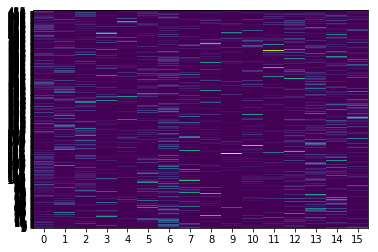

In [144]:
eps1_df = eps_df
plt.pcolor(eps1_df)
plt.yticks(np.arange(0.5, len(eps1_df.index), 1), eps1_df.index)
plt.xticks(np.arange(0.5, len(eps1_df.columns), 1), eps1_df.columns)
plt.show()

### Create Word Topics DataFrame

In [145]:
def get_nmf_topics(model, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict[i] = words;
    
    return pd.DataFrame(word_dict).transpose();

In [146]:
topics_df = get_nmf_topics(model=nmf,num_topics=16)
topics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,lying,truth,remember,lie,always,pretty,bottle,real,picture,protect,course,telling,needed,nice,great,alibi,feel,trouble,laundry,thanks
1,mental,behavior,insanity,psychiatric,opinion,psychiatrist,disorder,psychotic,insane,remember,expert,responsible,defect,action,study,legally,condition,feel,symptom,violent
2,privilege,statement,committee,ethic,alibi,legal,disciplinary,rule,relationship,privileged,confession,communication,subpoena,agreement,counsel,conversation,interest,situation,motion,former
3,tape,camera,confront,motion,therapist,contract,paint,opinion,rule,play,nervous,getting,admissible,pillow,count,recording,anybody,train,pressure,expected
4,soldier,war,military,terrorist,enemy,village,political,interrogation,order,general,command,prisoner,violence,president,technique,memo,speaks,united,vietnam,production
5,bank,account,business,paid,wire,transfer,fund,market,fraud,number,check,saving,cut,paper,hired,payment,deposit,larceny,document,steal
6,plea,degree,guilty,manslaughter,count,bail,immunity,conspiracy,felony,plead,jail,paid,walk,conviction,number,offer,minute,criminal,somebody,street
7,racism,race,racist,racial,hate,affirmative,african,self,action,street,train,harlem,entire,agency,irrelevant,interview,crowd,speech,play,prejudice
8,religious,religion,belief,spiritual,bible,guidance,prayer,confession,lord,soul,evil,motion,pray,sin,scared,courtroom,devil,human,save,accept
9,governor,campaign,political,district,corruption,election,privilege,appointment,business,executive,elected,indictment,authority,check,official,practically,penalty,bribe,general,power


### Create Topics in Episode DataFrame

Find Top Topic per Episode

In [147]:
max_topic = nmf_vecs.argmax(axis = 1)
topic_df = pd.DataFrame(max_topic)
topic_df = topic_df.rename({0:"topic"},axis=1)
topic_df.head()

,topic
0,2
1,15
2,10
3,6
4,6


Find Top Topic Score Per Episode

In [148]:
max_topic_score = nmf_vecs.max(axis = 1)
topic_score_df = pd.DataFrame(max_topic_score)
topic_score_df = topic_score_df.rename({0:"score"},axis=1)
topic_score_df.head()

,score
0,0.076611
1,0.149230
2,0.576181
3,0.118947
4,0.160090


Big Episode Topic Matrix

In [149]:
episode_topics_df = pd.DataFrame(nmf_vecs)
episode_topics_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.062903,0.037253,0.076611,0.000000,0.000000,0.000000,0.003954,0.000000,0.000000,0.0,0.064699,0.000000,0.067244,0.00000,0.000000,0.000000
1,0.028742,0.000000,0.002842,0.011142,0.010861,0.000000,0.013107,0.107201,0.010512,0.0,0.012758,0.016451,0.005677,0.00000,0.069250,0.149230
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013061,0.000000,0.000000,0.0,0.576181,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.042310,0.027490,0.000000,0.000000,0.000251,0.002526,0.118947,0.009728,0.011485,0.0,0.019729,0.003435,0.047395,0.00849,0.002341,0.026162
4,0.014835,0.002864,0.000000,0.000000,0.000000,0.000000,0.160090,0.022448,0.000000,0.0,0.002069,0.002140,0.000000,0.00000,0.112904,0.000000


Merge Episode DataFrames Together

In [150]:
eps_topic_comb_df = episode_scripts_df.merge(topic_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.merge(topic_score_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.merge(episode_topics_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.drop(["first","second"],axis=1)
eps_topic_comb_df.head()

,season_ep,topic,score,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,s01e01,2,0.076611,0.062903,0.037253,0.076611,0.000000,0.000000,0.000000,0.003954,0.000000,0.000000,0.0,0.064699,0.000000,0.067244,0.00000,0.000000,0.000000
1,s01e02,15,0.149230,0.028742,0.000000,0.002842,0.011142,0.010861,0.000000,0.013107,0.107201,0.010512,0.0,0.012758,0.016451,0.005677,0.00000,0.069250,0.149230
2,s01e03,10,0.576181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013061,0.000000,0.000000,0.0,0.576181,0.000000,0.000000,0.00000,0.000000,0.000000
3,s01e04,6,0.118947,0.042310,0.027490,0.000000,0.000000,0.000251,0.002526,0.118947,0.009728,0.011485,0.0,0.019729,0.003435,0.047395,0.00849,0.002341,0.026162
4,s01e05,6,0.160090,0.014835,0.002864,0.000000,0.000000,0.000000,0.000000,0.160090,0.022448,0.000000,0.0,0.002069,0.002140,0.000000,0.00000,0.112904,0.000000


### Name Topics

In [151]:
top_eps_per_topic = eps_topic_comb_df.sort_values(['topic','score'],ascending=False)[["season_ep","topic","score"]].groupby('topic').head(5)

In [159]:
top_eps_per_topic[top_eps_per_topic["topic"]==15]   #cycle through each time and look at scripts

,season_ep,topic,score
327,s15e03,15,0.499002
232,s11e04,15,0.437840
392,s17e22,15,0.413994
120,s06e10,15,0.280651
188,s09e08,15,0.279463


In [166]:
topic_dict = {0:"Lying Witness",1:"Plead Mental Illness",2:"Legal/Religious Privilege",3:"Video/Audio Evidence",
              4:"Military Personel",5:"Bank Records",6:"Plea Deal",7:"Racism",8:"Religious Beliefs",
              9:"NY Governor",10:"AIDS",11:"Websites/Online Behavior",12:"Government Grievances",
              13:"Appeal Verdict",14:"Internal Police Affairs",15:"Prison"}

In [167]:
topic_names_df = eps_topic_comb_df.rename(topic_dict,axis=1)
topic_names_df["topic"] = topic_names_df["topic"].map(topic_dict)

### Merge Topic Names with Episode Table & Export

In [168]:
topic_names_df.head()

,season_ep,topic,score,Lying Witness,Plead Mental Illness,Legal/Religious Privilege,Video/Audio Evidence,Military Personel,Bank Records,Plea Deal,Racism,Religious Beliefs,NY Governor,AIDS,Websites/Online Behavior,Government Grievances,Appeal Verdict,Internal Police Affairs,Prison
0,s01e01,Legal/Religious Privilege,0.076611,0.062903,0.037253,0.076611,0.000000,0.000000,0.000000,0.003954,0.000000,0.000000,0.0,0.064699,0.000000,0.067244,0.00000,0.000000,0.000000
1,s01e02,Prison,0.149230,0.028742,0.000000,0.002842,0.011142,0.010861,0.000000,0.013107,0.107201,0.010512,0.0,0.012758,0.016451,0.005677,0.00000,0.069250,0.149230
2,s01e03,AIDS,0.576181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013061,0.000000,0.000000,0.0,0.576181,0.000000,0.000000,0.00000,0.000000,0.000000
3,s01e04,Plea Deal,0.118947,0.042310,0.027490,0.000000,0.000000,0.000251,0.002526,0.118947,0.009728,0.011485,0.0,0.019729,0.003435,0.047395,0.00849,0.002341,0.026162
4,s01e05,Plea Deal,0.160090,0.014835,0.002864,0.000000,0.000000,0.000000,0.000000,0.160090,0.022448,0.000000,0.0,0.002069,0.002140,0.000000,0.00000,0.112904,0.000000


In [169]:
topic_names_df.to_csv("../05_Data/04_Model_Output/2nd_half_episodes_by_topic.csv")

### Merge Topic Names with Word Table & Export

In [170]:
topic_words_df = topic_count_df.merge(topics_df,how='outer', left_index=True, right_index=True)
topic_words_df = topic_words_df.rename(topic_dict,axis=0)
topic_words_df.head(10)

,num_eps,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
Lying Witness,43,lying,truth,remember,lie,always,pretty,bottle,real,picture,...,course,telling,needed,nice,great,alibi,feel,trouble,laundry,thanks
Plead Mental Illness,43,mental,behavior,insanity,psychiatric,opinion,psychiatrist,disorder,psychotic,insane,...,expert,responsible,defect,action,study,legally,condition,feel,symptom,violent
Legal/Religious Privilege,32,privilege,statement,committee,ethic,alibi,legal,disciplinary,rule,relationship,...,confession,communication,subpoena,agreement,counsel,conversation,interest,situation,motion,former
Video/Audio Evidence,29,tape,camera,confront,motion,therapist,contract,paint,opinion,rule,...,nervous,getting,admissible,pillow,count,recording,anybody,train,pressure,expected
Military Personel,13,soldier,war,military,terrorist,enemy,village,political,interrogation,order,...,command,prisoner,violence,president,technique,memo,speaks,united,vietnam,production
Bank Records,33,bank,account,business,paid,wire,transfer,fund,market,fraud,...,check,saving,cut,paper,hired,payment,deposit,larceny,document,steal
Plea Deal,57,plea,degree,guilty,manslaughter,count,bail,immunity,conspiracy,felony,...,jail,paid,walk,conviction,number,offer,minute,criminal,somebody,street
Racism,21,racism,race,racist,racial,hate,affirmative,african,self,action,...,train,harlem,entire,agency,irrelevant,interview,crowd,speech,play,prejudice
Religious Beliefs,16,religious,religion,belief,spiritual,bible,guidance,prayer,confession,lord,...,evil,motion,pray,sin,scared,courtroom,devil,human,save,accept
NY Governor,5,governor,campaign,political,district,corruption,election,privilege,appointment,business,...,elected,indictment,authority,check,official,practically,penalty,bribe,general,power


In [171]:
topic_words_df.to_csv("../05_Data/04_Model_Output/2nd_half_topic_words.csv")

### Pickle The Model

In [172]:
import pickle

with open('2nd_half_episode_model.pkl', 'wb') as picklefile:
    pickle.dump(nmf_vecs, picklefile)